# PRÁCTICAS DE REDES NEURONALES ARTIFICIALES (TSCAO): Parte III


## 4. REDES NEURONALES DE FUNCIÓN BASE RADIAL

**Código para implementar una Red Neuronal RBF**

Vamos a implementar la función base radial:

In [1]:
import numpy as np
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

Ahora necesitaremos usar el algoritmo de agrupación k-means para determinar los centros de los cluster. El siguiente código nos da los centros de clúster y las desviaciones estándar de los clústeres.

In [2]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
       Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

Este código implementa el algoritmo de clustering k-means y calcula las desviaciones estándar. Si hay un cluster con ninguno o uno de los puntos asignados, simplemente promediamos la desviación estándar de los otros grupos. (No podemos calcular la desviación estándar sin puntos de datos, y la desviación estándar de un solo punto de datos es 0).

Ahora implementaremos la clase RBF:

In [49]:
from sklearn.base import BaseEstimator
class RBFNet(BaseEstimator):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True, verbose=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.verbose = verbose
        self.w = np.random.randn(self.k)
        self.b = np.random.randn(1)
                
    def fit(self, X, y):
        if self.w.shape[0] != self.k:
            self.w = np.random.randn(self.k)
            self.b = np.random.randn(1)
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        # training
        for _ in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                if self.verbose:
                    print('Loss: {0:.2f}'.format(loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
            
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

Tenemos varios parámetros que elegir para la RBF: el número de bases, la tasa de aprendizaje, la cantidad de épocas, y si queremos usar las desviaciones estándar de k-means. También inicializamos los pesos y el sesgo. Recordando que una red RBF es una red de 2 capas modificada, por lo que solo hay un vector de pesos y un solo sesgo en el nodo de salida, ya que estamos aproximando una función 1D (específicamente, una salida). Si tuviéramos una función con múltiples salidas (una función con una salida con valor vectorial), usaríamos múltiples neuronas
de salida y nuestros pesos serían una matriz y nuestro sesgo un vector.

Luego, tenemos que escribir nuestra función de ajuste para calcular nuestros pesos y sesgos. En las primeras líneas, usamos las desviaciones estándar del algoritmo k-medias modificado, o forzamos a todas las bases a usar la misma desviación estándar calculada a partir de la fórmula. El resto es similar a la propagación hacia atrás, donde propagamos nuestra entrada en el futuro y actualizamos nuestros pesos hacia atrás.

    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                print('Loss: {0:.2f}'.format(loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error

Se debe tener en cuenta que estamos imprimiendo el error en cada paso. También estamos realizando una actualización en línea, lo que significa que actualizamos nuestros pesos y sesgos para cada entrada.
Alternativamente, podríamos haber realizado una actualización por lotes, donde actualizamos nuestros parámetros después de ver todos los datos de entrenamiento, o una actualización de minibatch, donde actualizamos nuestros parámetros después de ver un subconjunto de los datos de entrenamiento.

Hacer una predicción será tan simple como propagar nuestra entrada hacia adelante:

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

Hay que tener en cuenta que estamos permitiendo una matriz de entradas, donde cada fila es un ejemplo.

Ya podemos utilizar nuestro código para un ejemplo. Para nuestros datos de entrenamiento, generaremos 100 muestras de la función seno. Luego, agregaremos un poco de ruido uniforme a nuestros datos.

In [4]:
# CONFIGURACIÓN 1
import numpy as np
import matplotlib.pyplot as plt

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
 
rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X, y)
 
y_pred = rbfnet.predict(X)

Loss: 0.26
Loss: 0.25
Loss: 0.17
Loss: 0.19
Loss: 0.07
Loss: 0.10
Loss: 0.05
Loss: 0.01
Loss: 0.03
Loss: 0.04
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.06
Loss: 0.05
Loss: 0.05
Loss: 0.16
Loss: 0.23
Loss: 0.10
Loss: 0.35
Loss: 0.29
Loss: 0.28
Loss: 0.31
Loss: 0.34
Loss: 0.16
Loss: 0.27
Loss: 0.22
Loss: 0.13
Loss: 0.26
Loss: 0.16
Loss: 0.13
Loss: 0.14
Loss: 0.17
Loss: 0.11
Loss: 0.14
Loss: 0.09
Loss: 0.09
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.04
Loss: 0.04
Loss: 0.04
Loss: 0.02
Loss: 0.11
Loss: 0.06
Loss: 0.11
Loss: 0.15
Loss: 0.07
Loss: 0.07
Loss: 0.06
Loss: 0.07
Loss: 0.03
Loss: 0.02
Loss: 0.04
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.05
Loss: 0.10
Loss: 0.08
Loss: 0.06
Loss: 0.04
Loss: 0.07
Loss: 0.19
Loss: 0.17
Loss: 0.24
Loss: 0.43
Loss: 0.29
Loss: 0.27
Loss: 0.25
Loss: 0.32
Loss: 0.25
Loss: 0.16
Loss: 0.17
Loss: 0.09
Loss: 0.11
Loss: 0.15
Loss: 0.06

Dibujamos nuestra función aproximada para compararla con la real:

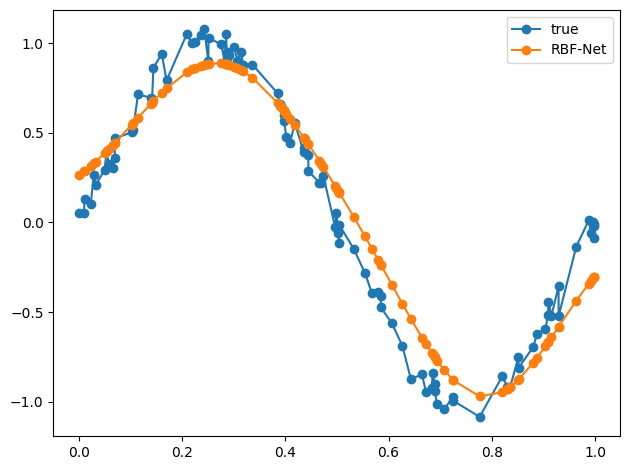

In [5]:
# CONFIGURACIÓN 1
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

Vemos que se ajusta bastante bien.

# Experimentos

## Incremento en número de bases

Loss: 0.66
Loss: 0.65
Loss: 0.81
Loss: 1.36
Loss: 1.00
Loss: 1.09
Loss: 1.44
Loss: 1.64
Loss: 1.92
Loss: 1.56
Loss: 1.86
Loss: 1.85
Loss: 1.96
Loss: 2.05
Loss: 1.67
Loss: 1.65
Loss: 1.85
Loss: 1.32
Loss: 1.02
Loss: 0.69
Loss: 0.59
Loss: 0.19
Loss: 0.07
Loss: 0.10
Loss: 0.03
Loss: 0.04
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.30
Loss: 0.94
Loss: 1.34
Loss: 1.39
Loss: 1.38
Loss: 1.29
Loss: 1.70
Loss: 1.98
Loss: 1.47
Loss: 1.79
Loss: 1.43
Loss: 1.49
Loss: 1.39
Loss: 1.33
Loss: 1.44
Loss: 1.50
Loss: 0.98
Loss: 0.91
Loss: 0.94
Loss: 0.94
Loss: 0.82
Loss: 0.98
Loss: 0.55
Loss: 0.47
Loss: 0.11
Loss: 0.09
Loss: 0.02
Loss: 0.00
Loss: 0.21
Loss: 0.46
Loss: 0.36
Loss: 0.60
Loss: 0.64
Loss: 1.01
Loss: 1.20
Loss: 0.94
Loss: 1.13
Loss: 1.30
Loss: 1.18
Loss: 1.44
Loss: 1.52
Loss: 1.42
Loss: 1.26
Loss: 1.46
Loss: 1.13
Loss: 1.40
Loss: 1.10
Loss: 0.96
Loss: 1.11
Loss: 1.15
Loss: 0.91
Loss: 0.92
Loss: 0.68
Loss: 0.76
Loss: 0.74
Loss: 0.50
Loss: 0.36
Loss: 0.25
Loss: 0.26
Loss: 0.10
Loss: 0.16
Loss: 0.08

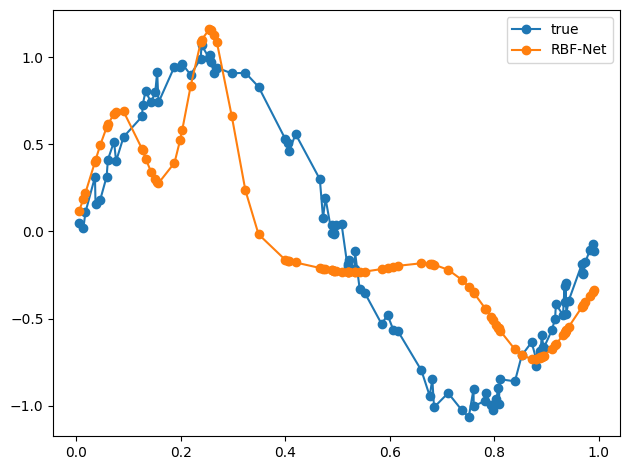

In [9]:
# CONFIGURACIÓN 1
import numpy as np
import matplotlib.pyplot as plt
seed = 140421
np.random.seed(seed)

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
 
rbfnet = RBFNet(lr=1e-2, k=4)
rbfnet.fit(X, y)
 
y_pred = rbfnet.predict(X)
# CONFIGURACIÓN 1
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()

Vemos que si aumentamos el número de bases obtenemos una función más flexible, permitiendo moldear funciones más complejas. No obstante, también estaríamos dando lugar a posibles problemáticas de sobre-aprendizaje o sobre-ajuste, donde ajustamos también el error de entrada. Se puede observar que hemos sobre-ajustado al fijarnos que ahora tenemos una mayor distancia con respecto a la función de entrada en los sitios en los cuales se realizan los cambios de base.

Si realizamos un experimento incrementando el número de bases desde 4 a 128 vemos como logramos casi moldear la función de entrada por completo de forma cada vez más compleja:

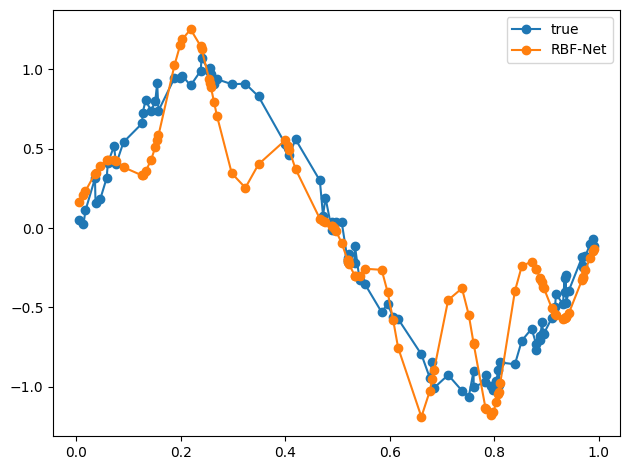

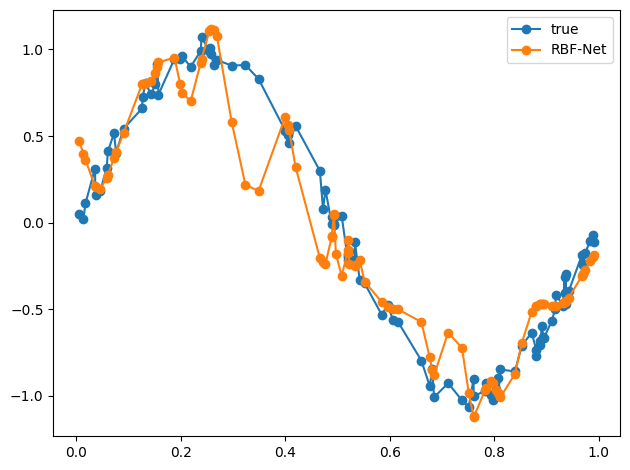

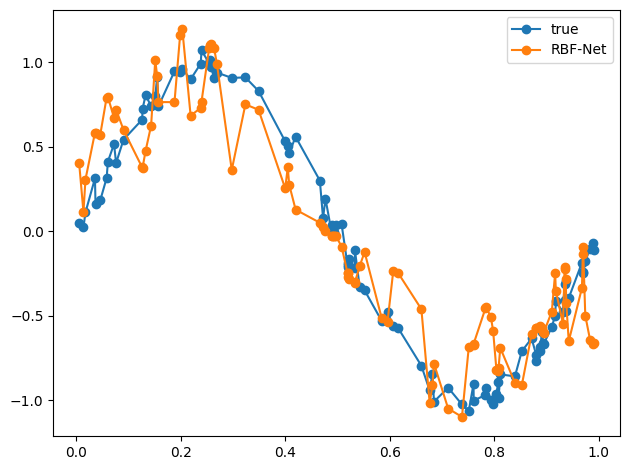

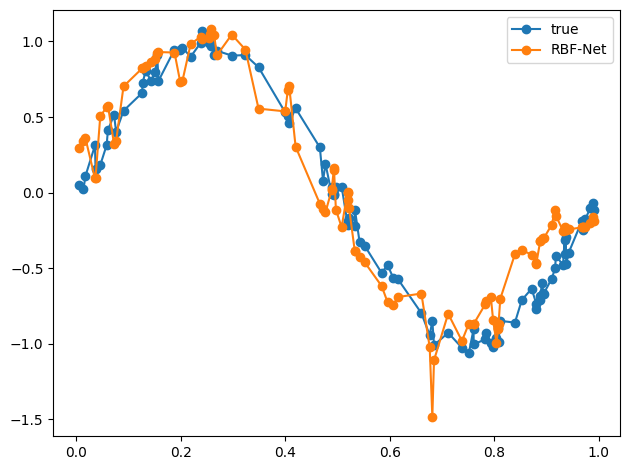

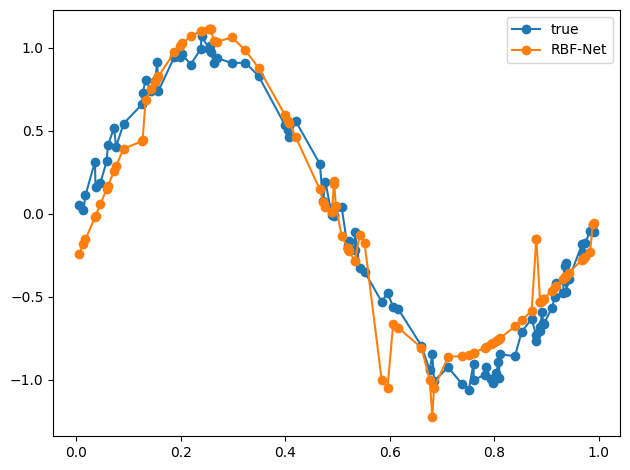

In [19]:
# CONFIGURACIÓN 1
import numpy as np
import matplotlib.pyplot as plt
seed = 140421
np.random.seed(seed)

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

for k in [8, 16, 32, 64, 128]:
    rbfnet = RBFNet(lr=1e-2, k=k, verbose=False)
    rbfnet.fit(X, y)
    
    y_pred = rbfnet.predict(X)
    # CONFIGURACIÓN 1
    plt.plot(X, y, '-o', label='true')
    plt.plot(X, y_pred, '-o', label='RBF-Net')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Desviación estándar única

Loss: 0.24
Loss: 0.24
Loss: 0.15
Loss: 0.02
Loss: 0.08
Loss: 0.05
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.06
Loss: 0.19
Loss: 0.25
Loss: 0.34
Loss: 0.28
Loss: 0.35
Loss: 0.50
Loss: 0.27
Loss: 0.60
Loss: 0.60
Loss: 0.61
Loss: 0.52
Loss: 0.68
Loss: 0.79
Loss: 0.65
Loss: 0.65
Loss: 0.57
Loss: 0.46
Loss: 0.49
Loss: 0.44
Loss: 0.43
Loss: 0.32
Loss: 0.05
Loss: 0.04
Loss: 0.02
Loss: 0.05
Loss: 0.01
Loss: 0.10
Loss: 0.04
Loss: 0.17
Loss: 0.13
Loss: 0.16
Loss: 0.16
Loss: 0.12
Loss: 0.13
Loss: 0.36
Loss: 0.37
Loss: 0.33
Loss: 0.29
Loss: 0.36
Loss: 0.24
Loss: 0.50
Loss: 0.53
Loss: 0.89
Loss: 0.79
Loss: 0.95
Loss: 0.96
Loss: 1.55
Loss: 1.93
Loss: 1.62
Loss: 2.00
Loss: 1.79
Loss: 2.08
Loss: 2.14
Loss: 1.65
Loss: 1.85
Loss: 1.75
Loss: 1.57
Loss: 1.71
Loss: 1.73
Loss: 1.52
Loss: 1.31
Loss: 1.48
Loss: 1.11
Loss: 1.15
Loss: 0.84
Loss: 0.72
Loss: 0.88
Loss: 0.92
Loss: 0.74
Loss: 0.75
Loss: 0.55
Loss: 0.64
Loss: 0.62
Loss: 0.48
Loss: 0.39
Loss: 0.28
Loss: 0.36
Loss: 0.19
Loss: 0.27
Loss: 0.16

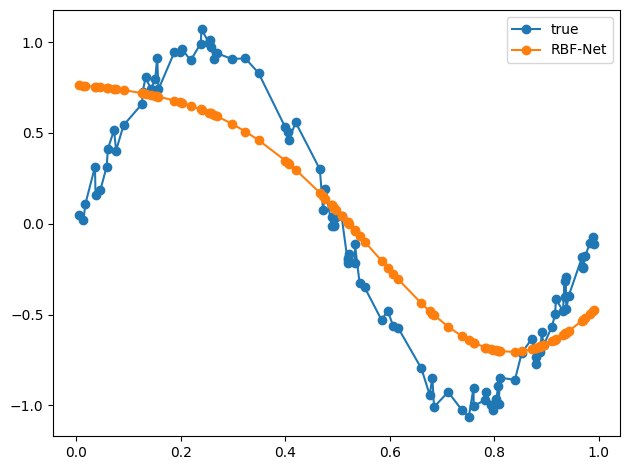

In [20]:
# CONFIGURACIÓN 1
import numpy as np
import matplotlib.pyplot as plt
seed = 140421
np.random.seed(seed)

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

rbfnet = RBFNet(lr=1e-2, k=2, inferStds=False, verbose=True)
rbfnet.fit(X, y)

y_pred = rbfnet.predict(X)
# CONFIGURACIÓN 1
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

Observamos que si utilizamos una desviación estándar única tenemos una función más suave. 
En este caso, al utilizar la misma desviación estándar, tendríamos que aumentar el número de bases para lograr moldear funciones más complejas. A continuación vemos el resultado de ir incrementando el número de bases fijando la desviación estándar

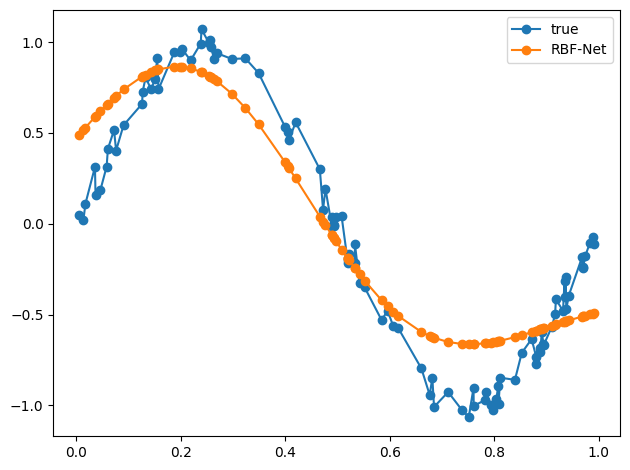

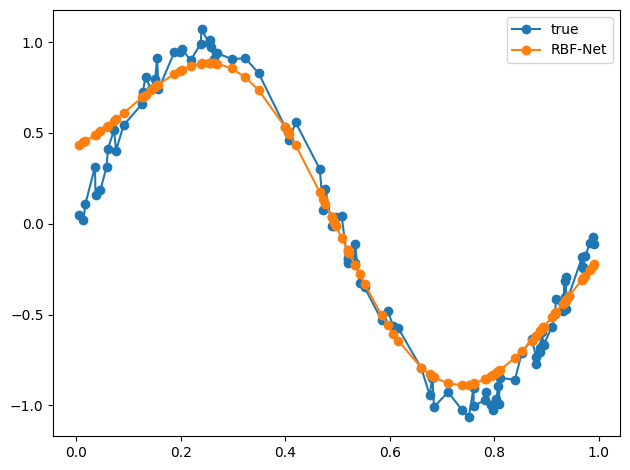

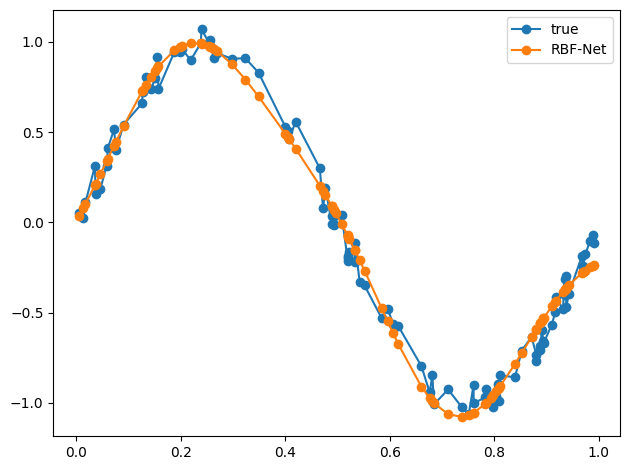

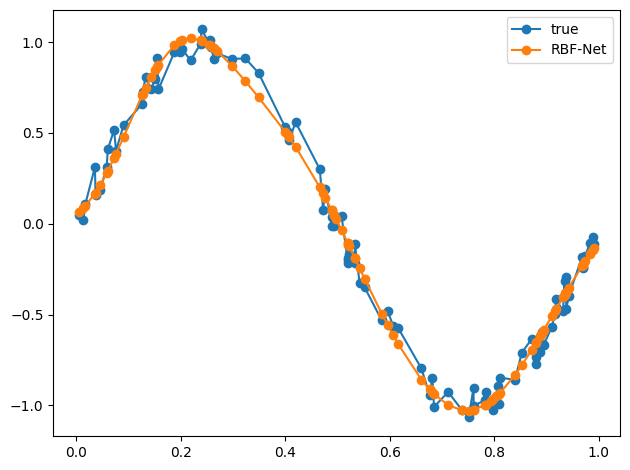

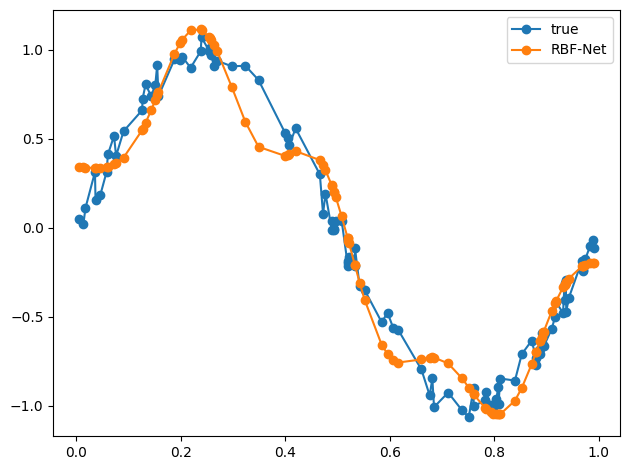

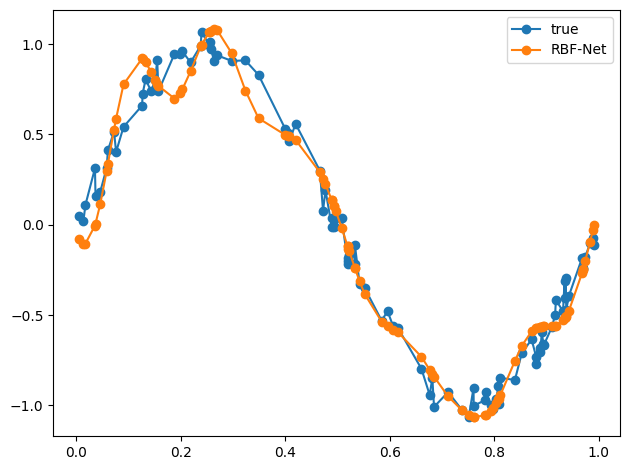

In [22]:
# CONFIGURACIÓN 1
import numpy as np
import matplotlib.pyplot as plt
seed = 140421
np.random.seed(seed)

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

for k in [4, 8, 16, 32, 64, 128]:
    rbfnet = RBFNet(lr=1e-2, k=k, verbose=False, inferStds=False)
    rbfnet.fit(X, y)
    
    y_pred = rbfnet.predict(X)
    # CONFIGURACIÓN 1
    plt.plot(X, y, '-o', label='true')
    plt.plot(X, y_pred, '-o', label='RBF-Net')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Observamos que con 16 y 32 bases, al utilizar desviaciones únicas, moldeamos casi a la perfección la función de entrada. Si dicha función estuviera excenta de error, tendríamos una aproximación casi exacta de la misma.

# Buscar mejor red.

Realizamos algunas modificaciones mínimas a la clase RBFNet para poder utilizar los métodos de sklearn para búsqueda exhaustiva de hiper-parámetros.

In [50]:
# CONFIGURACIÓN 1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
seed = 140421
np.random.seed(seed)

# sample inputs and add noise
NUM_SAMPLES = 100
size = 1.0
X = np.random.uniform(0., size, NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise


param_grid = dict(
    lr=[1e-3, 1e-2, 1e-1],
    k=[2, 4, 8, 16, 32],
    inferStds=[False, True],
)

cv = GridSearchCV( 
    RBFNet(verbose=False), 
    param_grid=param_grid, 
    scoring=["neg_mean_squared_error", "neg_mean_absolute_error"], 
    refit="neg_mean_squared_error",
    cv=3,
    error_score="raise",
)

cv.fit(X, y)

GridSearchCV(cv=3, error_score='raise', estimator=RBFNet(verbose=False),
             param_grid={'inferStds': [False, True], 'k': [2, 4, 8, 16, 32],
                         'lr': [0.001, 0.01, 0.1]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [52]:
import pandas as pd 

with pd.option_context("display.max_columns", None): 
    display(pd.DataFrame(cv.cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_inferStds,param_k,param_lr,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.078890,0.011684,0.000775,0.000096,False,2,0.001,"{'inferStds': False, 'k': 2, 'lr': 0.001}",-0.340597,-0.233322,-0.782516,-0.452145,0.237677,13,-0.511319,-0.420181,-0.870257,-0.600586,0.194282,16
1,0.070446,0.000483,0.000705,0.000074,False,2,0.010,"{'inferStds': False, 'k': 2, 'lr': 0.01}",-0.436331,-0.180752,-0.445222,-0.354102,0.122630,10,-0.582201,-0.370504,-0.559965,-0.504223,0.094989,10
2,0.070383,0.000353,0.000654,0.000033,False,2,0.100,"{'inferStds': False, 'k': 2, 'lr': 0.1}",-1.559118,-0.519921,-1.299208,-1.126083,0.441560,29,-1.099897,-0.661784,-1.036125,-0.932602,0.193259,29
3,0.083934,0.000482,0.000782,0.000038,False,4,0.001,"{'inferStds': False, 'k': 4, 'lr': 0.001}",-2.552939,-0.681406,-0.803713,-1.346019,0.854881,30,-1.565632,-0.780803,-0.819501,-1.055312,0.361196,30
4,0.091493,0.008483,0.001048,0.000335,False,4,0.010,"{'inferStds': False, 'k': 4, 'lr': 0.01}",-0.200376,-0.077173,-0.062094,-0.113214,0.061939,2,-0.327547,-0.229260,-0.203528,-0.253445,0.053441,1
5,0.085178,0.000734,0.000857,0.000075,False,4,0.100,"{'inferStds': False, 'k': 4, 'lr': 0.1}",-0.420746,-0.077503,-0.215681,-0.237976,0.141013,6,-0.580443,-0.204732,-0.405067,-0.396748,0.153496,6
6,0.111522,0.000916,0.000958,0.000060,False,8,0.001,"{'inferStds': False, 'k': 8, 'lr': 0.001}",-0.871660,-0.103556,-0.381987,-0.452401,0.317506,14,-0.889670,-0.278180,-0.585409,-0.584419,0.249641,14
7,0.111879,0.000683,0.000925,0.000028,False,8,0.010,"{'inferStds': False, 'k': 8, 'lr': 0.01}",-0.244269,-0.474091,-0.195936,-0.304766,0.121346,9,-0.354282,-0.673857,-0.382854,-0.470331,0.144387,9
8,0.111897,0.000522,0.000986,0.000055,False,8,0.100,"{'inferStds': False, 'k': 8, 'lr': 0.1}",-0.516097,-0.016568,-0.065155,-0.199273,0.224905,3,-0.602480,-0.106988,-0.202970,-0.304146,0.214562,3
9,0.167673,0.001162,0.001191,0.000006,False,16,0.001,"{'inferStds': False, 'k': 16, 'lr': 0.001}",-0.130036,-0.716410,-0.473845,-0.440097,0.240573,12,-0.332565,-0.824574,-0.664580,-0.607239,0.204913,17


In [51]:
print(cv.best_params_, cv.best_score_)

{'inferStds': False, 'k': 16, 'lr': 0.1} -0.09451527094572544


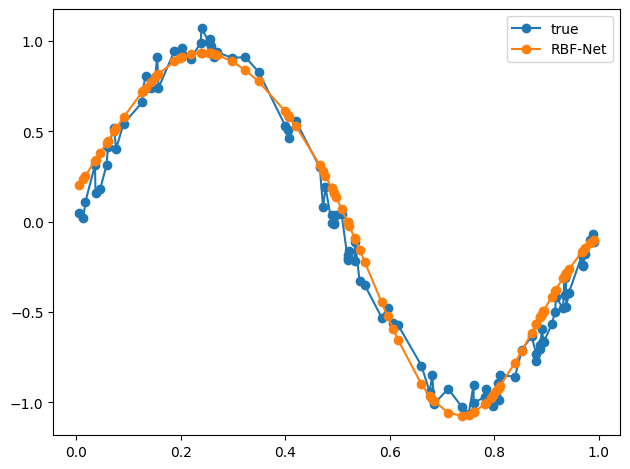

In [53]:
y_pred = cv.best_estimator_.predict(X)
# CONFIGURACIÓN 1
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

El mejor modelo finalmente es utilizar una desviación típica única, con un total de 16 bases y un ratio de aprendizaje de 0.1. Con ello, obtenemos el mejor error cuadrático medio. Y, como podemos observar en la Figura anterior, obtenemos una función muy parecida a la de entrada.

El hecho de utilizar una misma desviación típica introduce cierta regularización sobre la red. Incrementar el número de bases aumenta un la flexibilidad de la misma. En conjunto, con el equilibrio entre esos dos parámetros, obtenemos una función capaz de modelar diferentes funciones sin cambios bruscos de tendencia. Lo que nos permite modelar la función de entrada que es una uniforme cíclica con poco ruido (pequeñas variaciones) de forma muy eficaz.